In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 2.0MB/s 


In [ ]:

### Import necessary dependencies
import numpy as np
import pandas as pd
import calendar
import datetime
from dateutil.relativedelta import relativedelta
import category_encoders as ce
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso 
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge,Lasso,LassoLarsCV
from  scipy.stats import zscore
import plotly.express as px
import plotly.offline as pyoff
import plotly.graph_objs as go

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#DEFINING MEAN ABSOLUTE SCALED ERROR(MASE) METRICS FUNCTION:

In [ ]:
#MEAN ABSOLUTE SCALED ERROR METRICS FUNCTION
def MASE(y_train,y_test,y_hat):
  return (((y_train.shape[0]-1)/y_test.shape[0])*(np.sum(np.abs(y_test-y_hat))))/(np.sum(np.abs(y_train[1:]-y_train[0:-1])))

# Read in all data files

In [ ]:
### Read all files
trainb=pd.read_csv('/content/drive/My Drive/contraceptive_logistics_data.csv')
submission_usaid=pd.read_csv('/content/drive/My Drive/submission_format.csv')
sub_zindi=pd.read_csv('/content/drive/My Drive/SampleSubmission_usaid.csv')
contraceptive_case_data_monthly=pd.read_csv('/content/drive/My Drive/contraceptive_case_data_monthly.csv')
product=pd.read_csv('/content/drive/My Drive/product.csv')
service_delivery_site_data=pd.read_csv('/content/drive/My Drive/service_delivery_site_data.csv')
contraceptive_case_data_annual=pd.read_csv('/content/drive/My Drive/contraceptive_case_data_annual.csv')

'''path_read='drive/My Drive/zindi/Final Data/'
trainb=pd.read_csv(path_read+'contraceptive_logistics_data.csv')
submission_usaid=pd.read_csv(path_read+'submission_format.csv')
sub_zindi=pd.read_csv(path_read+'SampleSubmission.csv')
contraceptive_case_data_monthly=pd.read_csv(path_read+'contraceptive_case_data_monthly.csv')
product=pd.read_csv(path_read+'product.csv')
service_delivery_site_data=pd.read_csv(path_read+'service_delivery_site_data.csv')
contraceptive_case_data_annual=pd.read_csv(path_read+'contraceptive_case_data_annual.csv')'''


### merge product file and service_delivery_site_data file with contraceptive_logistics_data
trainb=trainb.merge(service_delivery_site_data[['site_code','site_type','site_latitude','site_longitude']],on='site_code')
trainb=trainb.merge(product[['product_code','product_type']],on='product_code')

### Create two columns ID and calendar. ID and calendar will be used later in the creation of the training data and the test data
trainb['ID']=trainb.year.astype(str)+' X '+trainb.month.astype(str)+' X '+trainb['site_code']+' X '+trainb['product_code']
trainb['calendar']=trainb[['year','month']].apply(lambda x:datetime.datetime(x['year'],x['month'],calendar.monthrange(x['year'],x['month'])[1]),axis=1)

In [ ]:
### Calculate monthly stock distribution with respect to each year
stock_distribution_monthly = trainb.groupby(['year','month']).stock_distributed.sum().reset_index()

#BIVARIATE ANALYSIS

In [ ]:
#plot monthly stock ditribution
plot_data = [
    go.Scatter(
        x=stock_distribution_monthly['month'],
        y=stock_distribution_monthly['stock_distributed'],
    )
]
plot_layout = go.Layout(
        title='Monthly stock distributed'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Estimate for product per site for each month

In [ ]:
### Estimate for product per site for each month
Total_stock_distributed =trainb.groupby(['month','district','site_code']).product_code.sum().reset_index()
Total_stock_distributed.rename({'product_code':'Total_product_on_month_basis_for_each_site_code'}, axis=1, inplace=True)

# A function to return a count for product per site

In [ ]:
## A function to return a count for product per site
def count_product(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

Total_stock_distributed['Total_product_persite'] = Total_stock_distributed['Total_product_on_month_basis_for_each_site_code'].apply(lambda x: len(x) - x.count(" "))

In [ ]:
### Divide the series by the total length of fixed string to scale counting
Total_stock_distributed['Total_product_persite']= Total_stock_distributed['Total_product_persite']/7
Total_stock_distributed['Total_product_persite']=Total_stock_distributed['Total_product_persite'].astype(int)

In [ ]:
#Containerize Total product on monthly basis to a new variable Total product
Total_stock_distributed['Total_product']=Total_stock_distributed['Total_product_on_month_basis_for_each_site_code'].map(Total_stock_distributed['Total_product_on_month_basis_for_each_site_code'].value_counts())

In [ ]:
#Merge Stock distribution analysis to exiting data
trainb = pd.merge(Total_stock_distributed, trainb, how="inner", on=["month","site_code","district"])

In [ ]:
### Sort data by year and month
### first of all we sort the dataset by year and month to be sure that all the variables we are going to create will follow the evolution of time
trainb=trainb.sort_values(by=['year','month'],ascending=True)

# Removal of invalid zeros

In [ ]:
### removal of invalid zeros
trainb['som']=trainb[['stock_initial','stock_received','stock_distributed','stock_adjustment','stock_end']].sum(axis=1)
trainb=trainb.loc[trainb['som']!=0]
trainb=trainb.loc[~((trainb['stock_initial']>0)&(trainb['average_monthly_consumption']>0)&(trainb['stock_distributed']==0))]
trainb=trainb.loc[~((trainb['stock_initial']>0)&(trainb['stock_distributed']==0))]

# FEATURE ENGINEERING:

# Creating additional three(3) features(Manhattan distance, Haversine distance & Bearing) from the given long and lat coordinates:

In [ ]:
#Manhattan distnace
def manhattan_distance(lat, lon):
    a = np.abs(lat -lon)
    return a
trainb['manhattan_dist'] = manhattan_distance(trainb['site_latitude'].values, trainb['site_longitude'].values,)

In [ ]:
#Haversine distance
def haversine_array(lat, lon):
    lat1, lng1 = map(np.radians, (lat, lon))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat1
    lng = lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(0) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

trainb['distance_haversine'] = haversine_array(trainb['site_latitude'].values, trainb['site_longitude'].values)

In [ ]:
#Bearing
def bearing_array(lat, lng):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lat - lng)
    lat, lng = map(np.radians, (lat, lng))
    y = np.sin(lng_delta_rad) * np.cos(lat)
    x = np.cos(lat) * np.sin(lat) - np.sin(lng) * np.cos(lng) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))
trainb['bearing'] = bearing_array(trainb['site_latitude'].values, trainb['site_longitude'].values,)

# Scaling of numeric variables:

In [ ]:
### scaling of numeric variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cl=list(trainb.select_dtypes(include=['float','int']).columns)
cl.remove('year')
cl.remove('month')
cl.remove('site_latitude')
cl.remove('site_longitude')
cl.remove('bearing')
cl.remove('distance_haversine')
cl.remove('manhattan_dist')
cl.remove('stock_distributed')
trainb[cl]=scaler.fit_transform(trainb[cl])
### copy of stock_distributed before transformation (smoothing)
trainb['stock_distributed_cop']=trainb['stock_distributed'].copy()

# Smoothing stock_distributed to eliminate unwanted noise and reduce spikes. We use Exponentially Weighted Moving Average.

In [ ]:
### Smoothing stock_distributed to eliminate unwanted noise and reduce spikes. We use Exponentially Weighted Moving Average
trainb['ewm']=0
for site in trainb['site_code'].unique():
  for prod in trainb['product_code'].unique():
    trainb.loc[(trainb['site_code']==site)&(trainb['product_code']==prod),'ewm']=\
    trainb.loc[(trainb['site_code']==site)&(trainb['product_code']==prod),'stock_distributed'].ewm(min_periods=3,alpha=.6).mean().fillna(method='bfill').values

In [ ]:
### we calculate the difference between rows for the site_code and product_code and we fill missing values with 0
trainb['diff']=trainb.groupby(['site_code','product_code'])['stock_distributed'].diff()
trainb['diff']=trainb['diff'].fillna(0)

### Calculation of cumulative sum of  "diff" columns site_code and product_code. This is useful to keep information of the evolution of stock_distributed
trainb['cumsum_diff']=trainb.groupby(['site_code','product_code'])['diff'].cumsum()

### Calculation of cumulative sum, cumulative max and cumulative min for stock_distributed for site_code and product_code per year
trainb['cumsum']=trainb.groupby(['year','site_code','product_code'])['stock_distributed'].cumsum()
trainb['cummax']=trainb.groupby(['year','site_code','product_code'])['stock_distributed'].cummax()
trainb['cummin']=trainb.groupby(['year','site_code','product_code'])['stock_distributed'].cummin()

####Counts of unique product; so we could re-group per site on monthly basis
trainb['counts_of_product_code']=trainb['product_code'].map(trainb['product_code'].value_counts())
trainb['Availability_per_site_on_monthly_basis'] =trainb.groupby(['month','district','site_code'])['counts_of_product_code'].cumsum()

In [ ]:
#Concatenation of site and product code for relationship between unique product
trainb['site_product_concatenation']= trainb['site_code']+ '_'+trainb['product_code']

In [ ]:
### Our approach is to develop 3 models. If we are at month M, model_1 must predict the value of month M+1,model_2 must predict the value of month M+2
### and model_3 must predict the value of month M+3. With this approach we can predict the value for October, November and December.
### to achieve this we create 3 target variables (stock_distributed_t1,stock_distributed_t2 and stock_distributed_t3). If we are in month M the target variable for model_1 will be
### the value of stock_distributed in month m + 1 we call this variable stock_distributed_t1. The reasoning is the same for stock_distributed_t2 and stock_distributed_t3

trainb['shift_1']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(1)
trainb['shift_2']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(2)

trainb.loc[trainb['shift_1'].isnull(),'shift_1']=trainb.loc[trainb['shift_1'].isnull(),'average_monthly_consumption'].values
trainb.loc[trainb['shift_2'].isnull(),'shift_2']=trainb.loc[trainb['shift_2'].isnull(),'average_monthly_consumption'].values

trainb['stock_distributed_t1']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(-1)
trainb['stock_distributed_t2']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(-2)
trainb['stock_distributed_t3']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(-3)

### we fill the missing values with average_monthly_consumption columns. This columns gives a better result compared to stock_distributed
trainb.loc[trainb['stock_distributed_t1'].isnull(),'stock_distributed_t1']=trainb.loc[trainb['stock_distributed_t1'].isnull(),'average_monthly_consumption'].values
trainb.loc[trainb['stock_distributed_t2'].isnull(),'stock_distributed_t2']=trainb.loc[trainb['stock_distributed_t2'].isnull(),'average_monthly_consumption'].values
trainb.loc[trainb['stock_distributed_t3'].isnull(),'stock_distributed_t3']=trainb.loc[trainb['stock_distributed_t3'].isnull(),'average_monthly_consumption'].values

trainb['rolling_mean']=trainb[['shift_1','shift_2','stock_distributed']].mean(axis=1)

In [ ]:
### here we create aggregate feature mean,median and std
### we create a dictionnary to map  key columns with the columns we are going to aggregate

grp={'month,region,product_code':['stock_initial','stock_received','rolling_mean'],'month,district,product_code':['stock_initial','stock_received','rolling_mean'],
     'month,district,site_code,product_code':['stock_initial','stock_received','rolling_mean'],
     'month,region,product_type':['stock_initial','stock_received','rolling_mean',],'month,district,product_type':['stock_initial','stock_received','rolling_mean'],
     'month,district,site_code,product_type':['stock_initial','stock_received','rolling_mean'],
     'region,product_code':['stock_initial','stock_received','rolling_mean'],'district,product_code':['stock_initial','stock_received','rolling_mean'],
     'district,site_code,product_code':['stock_initial','stock_received','rolling_mean'],
     'region,product_type':['stock_initial','stock_received','rolling_mean'],'district,product_type':['stock_initial','stock_received','rolling_mean'],
     'district,site_code,product_type':['stock_initial','stock_received','rolling_mean']}

In [ ]:
### we process the aggregation
for g in grp:
  dic={}
  for j in grp[g]:
    dic[j]=[np.mean,np.median,np.std]
  pp=trainb.groupby(g.split(',')).agg(dic).reset_index()
  pp.columns=[c[0] if c[1]=='' else g+'_'+c[0]+'_'+c[1] for c in pp.columns]
  trainb=trainb.merge(pp,on=g.split(','))

In [ ]:
#import seaborn as sns
#from matplotlib import pyplot as plt
#get correlations of each features in dataset
#corrmat = trainb.corr()
#top_corr_features = corrmat.index
#plt.figure(figsize=(15,10))
#plot heat map
#g=sns.heatmap(trainb.corr(),annot=True,cmap="RdYlGn")

In [ ]:
test=trainb.sort_values(by=['year','month'],ascending=True).drop_duplicates(subset=['site_code','product_code'],keep='last')
train=trainb.loc[~trainb['ID'].isin(test['ID'].values)]

# We make a one hot encoding for some categorical columns and we remove unnecessary variables

In [ ]:
### We make a one hot encoding for some categorical columns and we remove unnecessary variables
enc=ce.OneHotEncoder(cols=['region','district','product_code','site_type','product_type','site_product_concatenation'],drop_invariant=True,use_cat_names=True)
d_train=enc.fit_transform(train)
d_test=enc.transform(test)
col=list(d_train.columns)
col.remove('year')

col.remove('site_code')
col.remove('stock_ordered')
col.remove('stock_received')

col.remove('shift_1')
col.remove('shift_2')

col.remove('calendar')

col.remove('stock_initial')
col.remove('stock_adjustment')
col.remove('stock_stockout_days')

col.remove('stock_distributed')
col.remove('stock_distributed_t1')
col.remove('stock_distributed_t2')
col.remove('stock_distributed_t3')
col.remove('average_monthly_consumption')
col.remove('ID')
col.remove('diff')
col.remove('stock_distributed_cop')
col.remove('ewm')
col.remove('som')
col.remove('Total_product_on_month_basis_for_each_site_code')

#Initializing models:
# (i)  Model1+ls1 will be used to predict October, 
# (ii) Model2+ls2 will be used to predict November, 
# (iii) Model3+ls3 will be used to predict December respectively.

In [ ]:
# Model1+ls1 will be used to predict October:
model1=LGBMRegressor(num_leaves = 70,feature_fraction = 0.5,subsample = 0.8, max_depth=8,learning_rate=0.01,
                     n_estimators=1000,colsample_bytree=.4,bagging_fraction = 0.6,min_split_gain = 0.05, 
                     random_state=42,verbosity=1,silent=None,objective='regression',booster='gbtree',
                     n_jobs=-1, min_child_weight = 22)
ls1=Lasso(alpha=.95,normalize=False,random_state=42,max_iter=5000)


# Model2+ls2 will be used to predict November:
model2=LGBMRegressor(num_leaves = 70,feature_fraction = 0.5,subsample = 0.8, max_depth=8,learning_rate=0.01,
                     n_estimators=1000,colsample_bytree=.4,bagging_fraction = 0.6,min_split_gain = 0.05, 
                     random_state=42,verbosity=1,silent=None,objective='regression',booster='gbtree',
                     n_jobs=-1, min_child_weight = 22)
ls2=Lasso(alpha=.95,normalize=False,random_state=42,max_iter=5000)


# Model3+ls3 will be used to predict December:
model3=LGBMRegressor(num_leaves = 70,feature_fraction = 0.5,subsample = 0.8, max_depth=8,learning_rate=0.01,
                     n_estimators=1000,colsample_bytree=.4,bagging_fraction = 0.6,min_split_gain = 0.05, 
                     random_state=42,verbosity=1,silent=None,objective='regression',booster='gbtree',
                     n_jobs=-1, min_child_weight = 22)
ls3=Lasso(alpha=.95,normalize=False,random_state=42,max_iter=5000)                  

In [ ]:
### create 3 variables for the target label et 3 columns in test set to receive models prediction
y1='stock_distributed_t1'
y2='stock_distributed_t2'
y3='stock_distributed_t3'

In [ ]:
d_test['predicted1']=0
d_test['predicted2']=0
d_test['predicted3']=0

In [ ]:
### For each target select best features with ExtraTreesRegressor and store this features in dictionnary
clf = ExtraTreesRegressor(n_estimators=500,max_depth=10,random_state=42)

cl={}
for y in [y1,y2,y3]:
  clf.fit(d_train[col].fillna(0), d_train[y])
  model = SelectFromModel(clf, prefit=True,threshold='median')
  cl[y]=list(np.array(col)[model.get_support()])
  #cl[y]=col

In [ ]:
### train first model with selected feature and combine the predictions 
x_tr,y_tr=d_train[cl[y1]],d_train[y1]
model1.fit(x_tr,y_tr)
ls1.fit(x_tr.fillna(0),y_tr)
d_test['predicted1']=np.round(model1.predict(d_test[cl[y1]])*.75+ls1.predict(d_test[cl[y1]].fillna(0))*.25)

In [ ]:
### train second model with selected feature and combine the predictions
x_tr,y_tr=d_train[cl[y2]],d_train[y2]
model2.fit(x_tr,y_tr)
ls2.fit(x_tr.fillna(0),y_tr)
d_test['predicted2']=np.round(model2.predict(d_test[cl[y2]])*.75+ls2.predict(d_test[cl[y2]].fillna(0))*.25)

In [ ]:
### train third model with selected feature and combine the predictions
x_tr,y_tr=d_train[cl[y3]],d_train[y3]
model3.fit(x_tr,y_tr)
ls3.fit(x_tr.fillna(0),y_tr)
d_test['predicted3']=np.round(model3.predict(d_test[cl[y3]])*.75+ls3.predict(d_test[cl[y3]].fillna(0))*.25)

# Preparation of test set that's in line with USAID submission format:

In [ ]:
### Preparation of test set for the submission 

d_test['site_code']=d_test['ID'].str.split('X',expand=True)[2].str.strip()
d_test['product_code']=d_test['ID'].str.split('X',expand=True)[3].str.strip()
aux=d_test.sort_values(by=['year','month'])
aux.drop_duplicates(subset=['site_code','product_code'],keep='last',inplace=True)

aux['year']=2019
aux['month']=10
a=aux[['year','month','site_code','product_code','predicted1']]
a.rename(index=str,columns={'predicted1':'predicted_value'},inplace=True)


aux=d_test.sort_values(by=['year','month'])
aux.drop_duplicates(subset=['site_code','product_code'],keep='last',inplace=True)

aux['year']=2019
aux['month']=11
b=aux[['year','month','site_code','product_code','predicted2']]
b.rename(index=str,columns={'predicted2':'predicted_value'},inplace=True)


aux=d_test.sort_values(by=['year','month'])
aux.drop_duplicates(subset=['site_code','product_code'],keep='last',inplace=True)

aux['year']=2019
aux['month']=12
c=aux[['year','month','site_code','product_code','predicted3']]
c.rename(index=str,columns={'predicted3':'predicted_value'},inplace=True)

dd=pd.concat([a,b,c]).reset_index(drop=True)

In [ ]:
usaid_sub=submission_usaid[['year','month','site_code','product_code']].merge(dd,on=['year','month','site_code','product_code'],how='left')
### some site_code x product_code association does not exist in the training set but are present in the submission data. So we set the prediction of this association to 0
usaid_sub.fillna(0,inplace=True)
### Some predictions are negative, so we fix that by multiply this values with -1
usaid_sub.loc[usaid_sub['predicted_value']<0,'predicted_value']=-1*usaid_sub.loc[usaid_sub['predicted_value']<0,'predicted_value'].values
usaid_sub.to_csv('usaid_model_2.csv',index=False)

In [ ]:
usaid_sub.shape

(3115, 5)

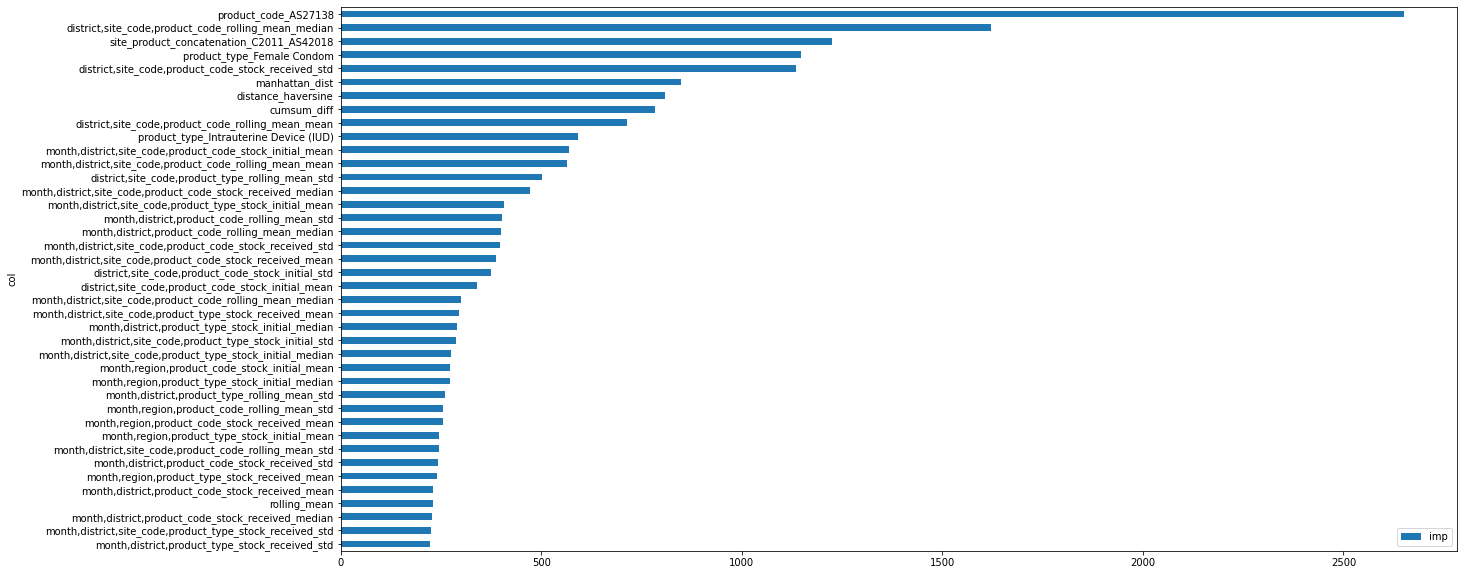

In [ ]:
fea_imp = pd.DataFrame({'imp':model1.feature_importances_, 'col': x_tr.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-40:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))   

In [ ]:
usaid_sub.head(50)

,year,month,site_code,product_code,predicted_value
0,2019,10,C4001,AS27134,21.0
1,2019,10,C4001,AS27132,1.0
2,2019,10,C4001,AS27000,6.0
3,2019,10,C4001,AS27137,3.0
4,2019,10,C4001,AS27138,5.0
5,2019,10,C4001,AS27133,37.0
6,2019,10,C4023,AS27000,14.0
7,2019,10,C4023,AS27133,44.0
8,2019,11,C4023,AS27000,13.0
9,2019,11,C4023,AS27133,42.0
